In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

In [6]:
os.chdir('..')

In [10]:
from utils.configuration import load_config
from data.hm_data import HMDataset

In [8]:
cfg = load_config('config.yml')

In [11]:
data = HMDataset(cfg.get('data_path'))

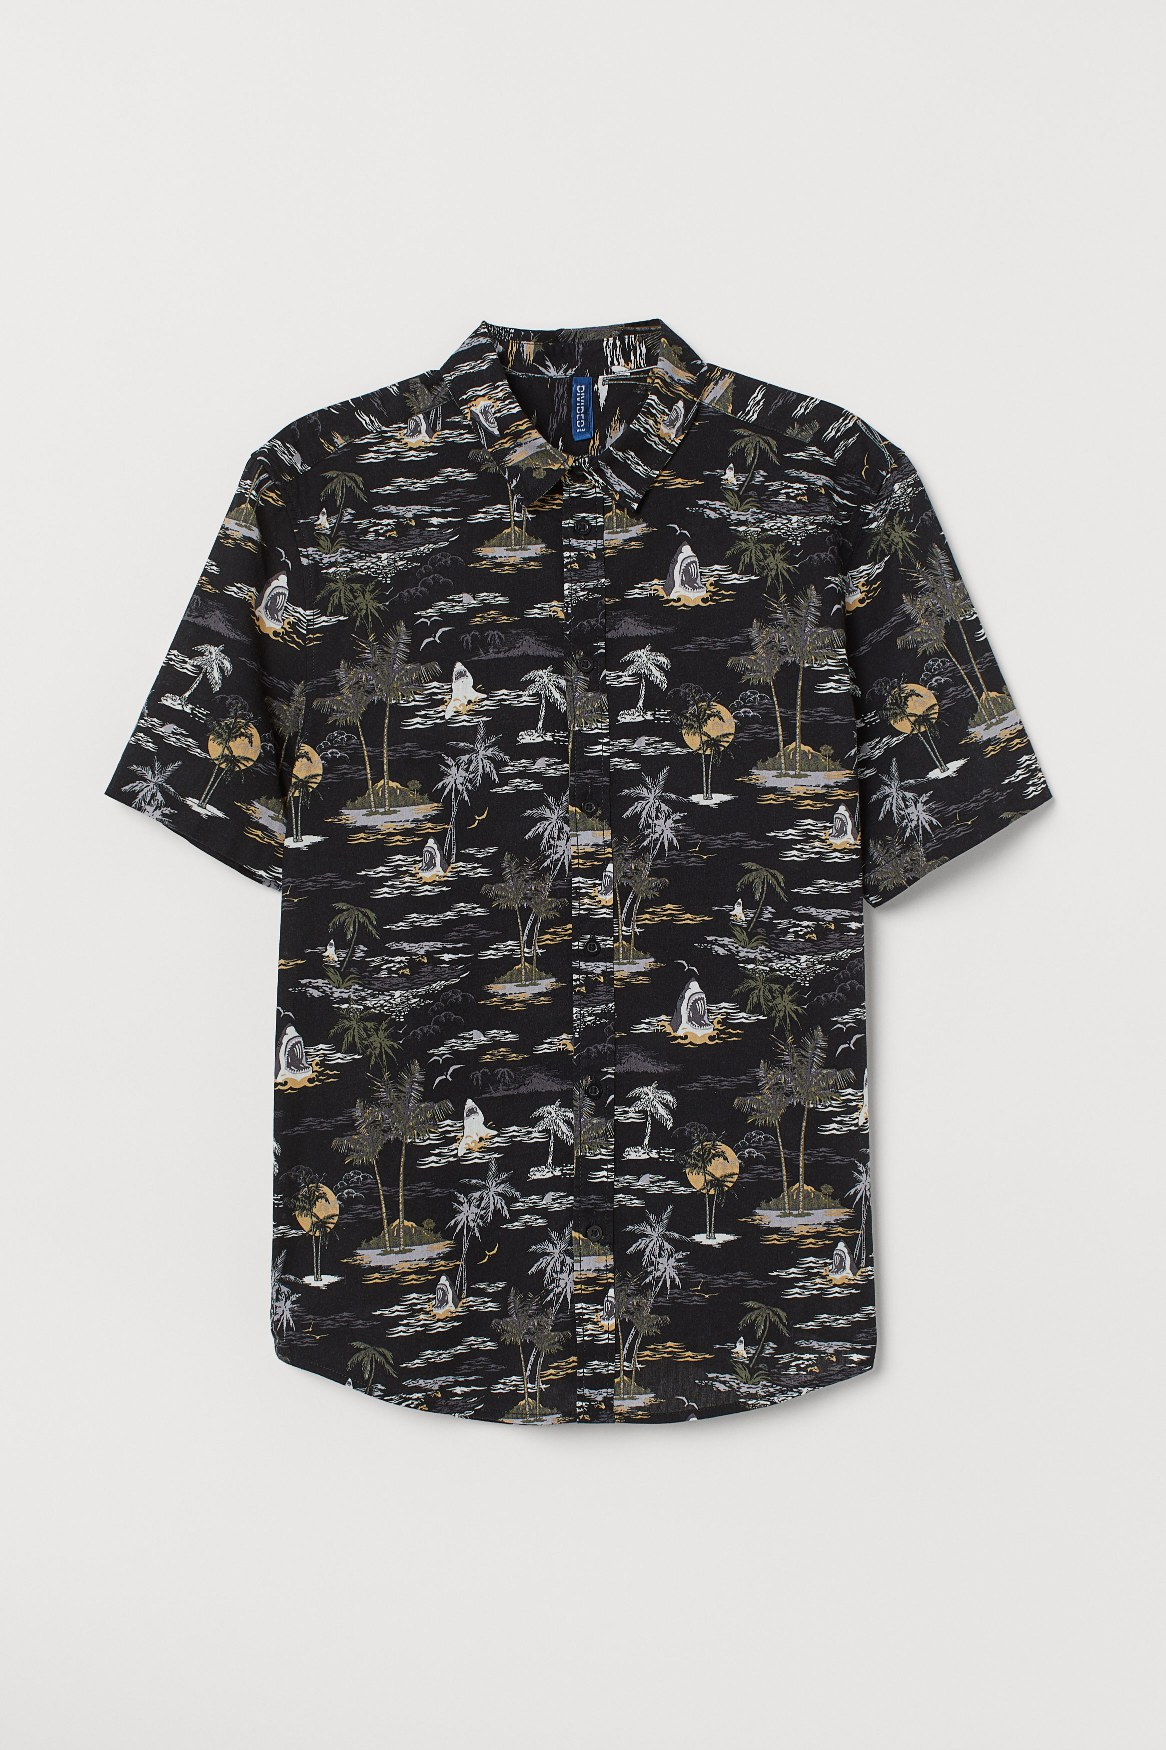

In [14]:
data[6]